# Latent Variable Models : applications and examples

In [1]:
%load_ext lab_black
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

## Reminder & warm-up

An EM algorithm is an iterative optimization of the following variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT$.

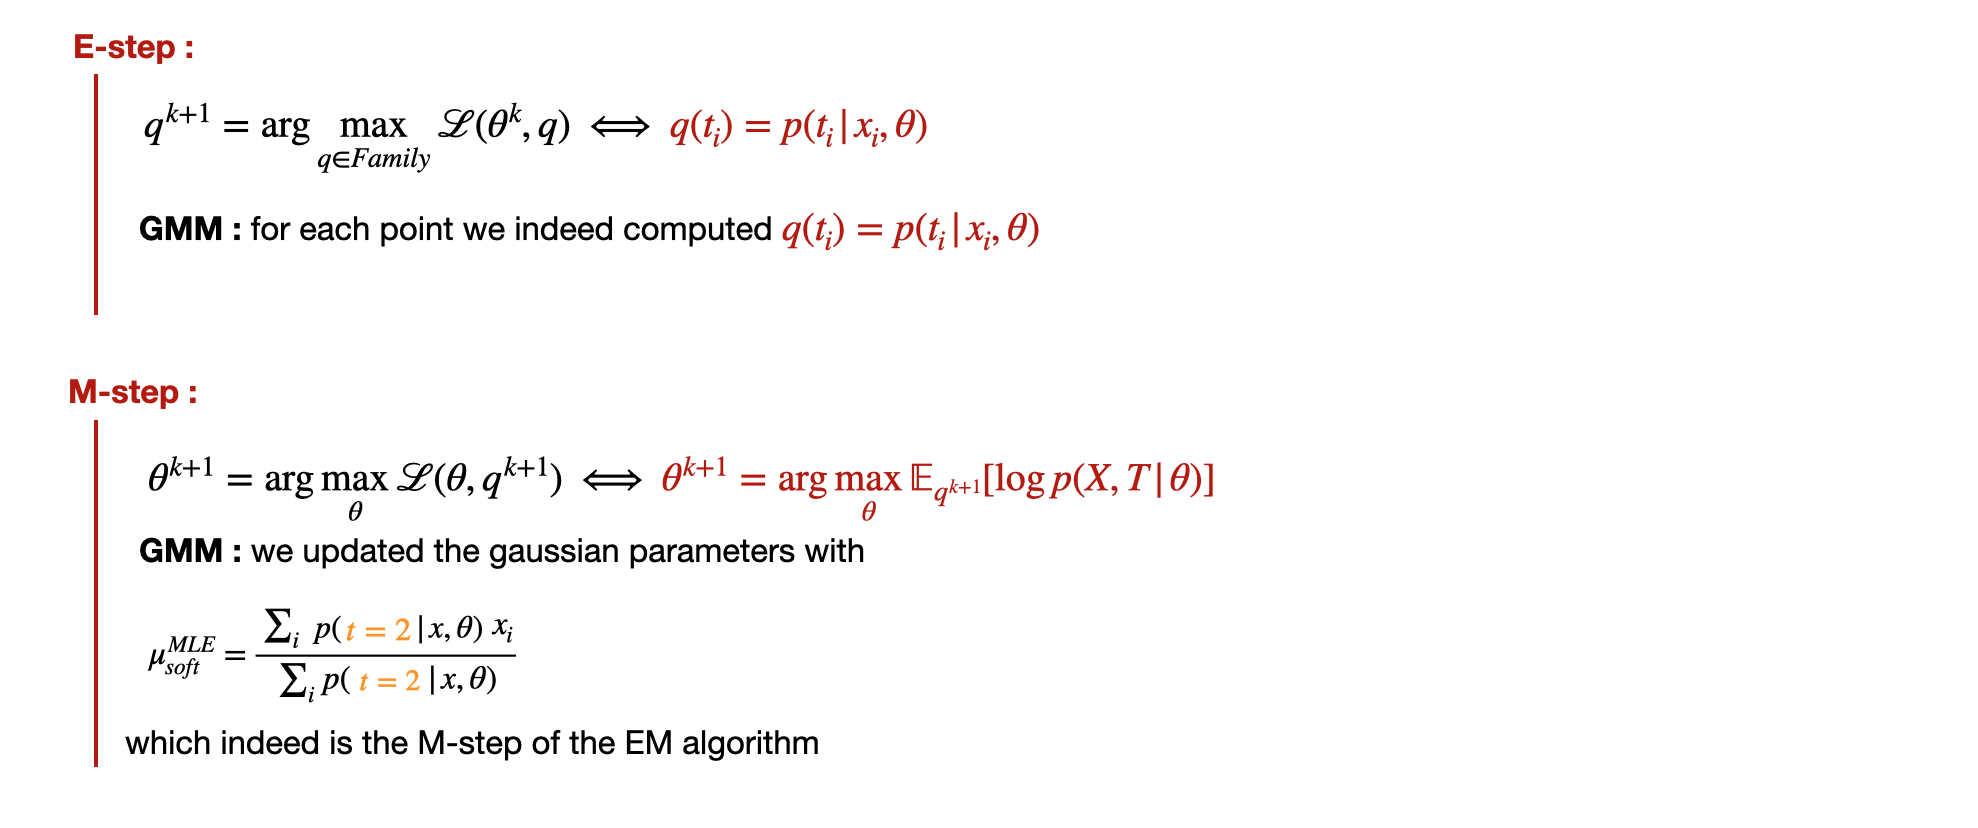

In [2]:
from sklearn.datasets import load_breast_cancer
import numpy as np

data = load_breast_cancer()
X = data["data"]
y = data["target"]

**Question 1 :** Give the shape of X and y.

In [3]:
X.shape, y.shape

((569, 30), (569,))

**Question 2 :** Plot the first two dimension of X and color the instances according to its class y

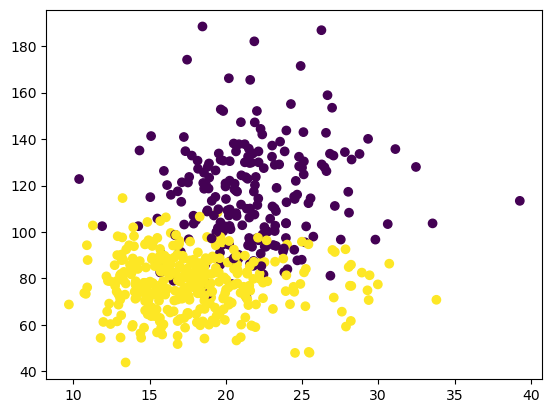

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(X[:, 1], X[:, 2], c=y)
plt.show()

For the sake of the following section, let us discard completely the class y.

## 1. Clustering : a probabilistic point of view with k-means

We recall that k-means is a clustering algorithm which has the following pseudo-algorotihm :

**Input :** number of clusters $K$, dataset $X$

**Output :** the clusters

1. Randomly initialize the parameters $\theta = \{centroid_1, \dots, centroid_K\}$

2. Repeat until convergence :
    - For each instance $x$, compute the closest centroid :
    $$
    k_i = \arg\min_{k} \lVert x_i - centroid_k \lVert^2
    $$
    
    - Update the centroids :
    $$
    centroid_k = \frac{\sum_{i:k_i=k} x_i}{|{i:k_i=k}|}
    $$

**Question 3 :** Define the function `kmeans_naive` and test it out on $X$ with $K=3$. Plot the first two dimensions of $X$ and color the instances according to its cluster

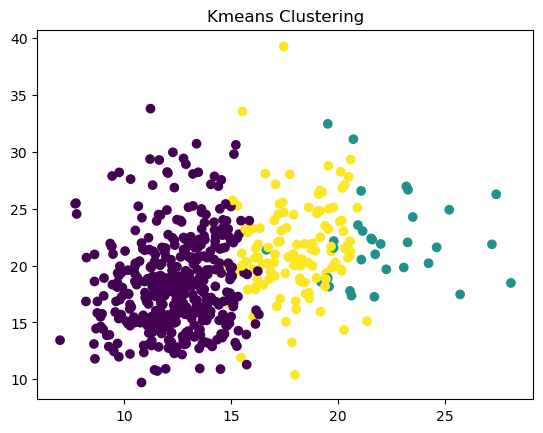

In [5]:
np.random.seed(42)


def kmeans_naive(X, K):
    m, n = X.shape
    centroids = X[np.random.choice(m, K, replace=False)]
    while True:
        cluster = get_cluster(X, centroids)
        new_centroids = np.array([X[cluster == k].mean(axis=0) for k in range(K)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return cluster, centroids


def get_cluster(X, centroids):
    dist_ls = []
    for x in X:
        dists = [np.linalg.norm(x - c) ** 2 for c in centroids]
        closest_centroid = np.argmin(dists)
        dist_ls.append(closest_centroid)
    return np.array(dist_ls)


cluster, centroids = kmeans_naive(X, 3)
plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.title("Kmeans Clustering")
plt.show()

**Question 4 :** Define the function `GMM_hard` (p.24) which fit a Gaussian Mixture Model (with hard clustering). We assume two things here 
- $\Sigma = I_d$ is **known** and is identical ;
- $\pi_k$ is known and is uniform.

In [6]:
import numpy as np
from scipy.stats import multivariate_normal


def GMM_hard(X, K, tol=1e-5):
    m, n = X.shape
    means = X[np.random.choice(m, K, replace=False)]
    converged = False
    while not converged:
        rv = np.array(
            [multivariate_normal(mean=mu, cov=np.eye(n)).pdf(X) for mu in means]
        )
        clusters = np.argmax(rv.T, axis=1)
        means_new = np.array([X[clusters == k].mean(axis=0) for k in range(K)])
        if np.max(np.linalg.norm(means_new - means, axis=1)) < tol:
            converged = True
        else:
            means = means_new

    return clusters, means

**Question 5 :** What do we see ?

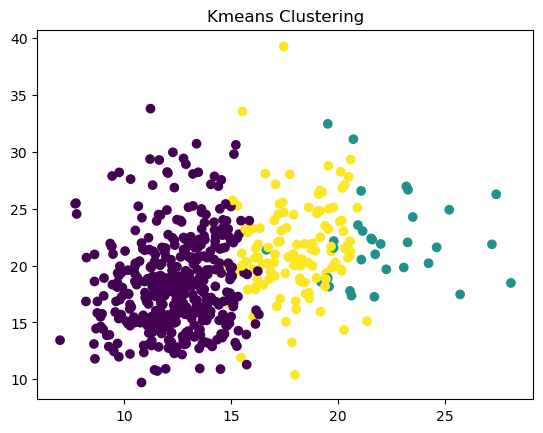

In [7]:
clusters, means = GMM_hard(X, 3)

plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.title("Kmeans Clustering")
plt.show()

**Question 5 :** Redefine `GMM_hard` and let us take assume that $\Sigma_k$ and $\pi_k$ are no longer known. Plot the results

**[OPTIONAL] Question 6 :** Define `GMM_soft` which fit a GMM with soft clustering. Plot the results

## 2. Dimensionality reduction : a probabilistic point of view with PCA

PPCA is a dimensionality reduction technique that is often used when we have some missing values in the dataset. We assume that each latent variable is normally distributed :
$$
t_i \sim \mathcal{N}(0, I_K)
$$

The instance $x$ associated is generated by the following projection :
$$
x_i | t_i \sim \mathcal{N}(W\cdot t_i + b, \Sigma)
$$

**Question 7 :** The PPCA is a general form of PCA. Indeed, we can observe it in marginalizing the latent variable. Find out the distribution of each instance $x | \theta$ (you can use the wikipedia table for the normal conjugacy).

In [8]:
m, n = X.shape
K = 3
W = np.random.randn(n, K)
b = np.zeros(n)
mean = b
Sigma = np.eye(n)
covariance = np.dot(W, W.T) + Sigma * np.eye(len(mean))
instance_dist = multivariate_normal(mean=mean, cov=covariance)
instance_dist.mean, instance_dist.cov

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[ 3.39676453e+00, -3.97842637e-01, -4.47270293e-01,
          1.78121289e+00,  5.15899625e-01, -6.24315075e-01,
         -1.94563365e+00, -8.60271511e-01,  1.15377654e+00,
         -2.34925201e-02, -6.67138256e-01,  1.98951425e+00,
         -1.62003617e+00, -2.50590392e+00,  1.11332480e+00,
         -2.37436803e+00,  2.85567544e+00, -3.34262878e-02,
         -2.87741142e-01,  5.34410177e+00, -3.55315974e-02,
         -2.23112133e-01, -1.90595183e+00, -6.19026495e-01,
          1.38060027e+00, -2.62279981e+00,  1.52850987e-01,
          2.42763885e+00,  2.67850745e-01, -1.71443983e+00],
        [-3.97842637e-01,  3.09986097e+00,  7.15434673e-01,
         -7.66611276e-01,  2.74775427e+00, -1.33332600e+00,
          1.03368186e+00,  1.03998144e+00, -3.82166522e-01,
          5.39409784e-01, -1.34652550e+00, -2.62238978e-01,
          3.04642541e

**Question 8 :** Compute the E-step of the PPCA

**Question 9 :** Compute the M-step of the PPCA

**Question 10 :** Do a reduction of dimensionality with PPCA and plot the results with its true labels on a 2D graph

### A quick look on the dimensionality reduction with PCA and t-SNE

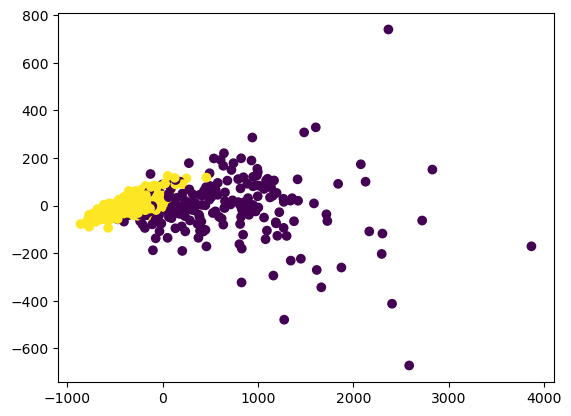

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis")

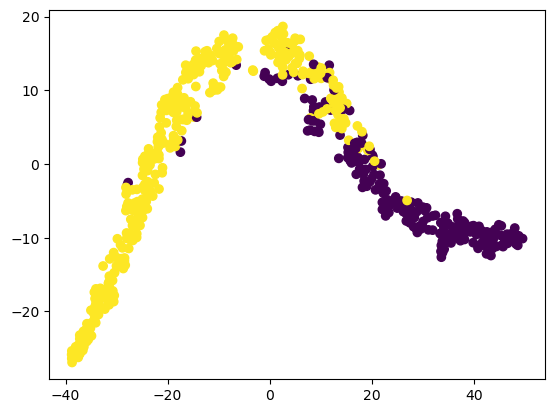

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="viridis")